***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#6' style="text-decoration : none; color : #000000;">5. Comparing Results</a></h2>  
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_Test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [4]:
df=pd.read_csv('Html.csv')
df.drop(['Unnamed: 0','Malicious'],axis=1,inplace=True)

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)

rem=['link_rel_wlwmanifest','script_src_absolute','base_count','img_src_relative','link_href_relative',
     'form_action_absolute','tbody_count','link_count',  'base_href_absolute', 'img_srcset_relative','link_rel_EditURI',
     'form_enctype_application/x-www-form-urlencoded','a_href_relative','iframe_src_absolute',
     'iframe_sandbox_allow_same_origin_count','a_href_absolute','base_href_relative','link_type_application/wlwmanifest+xml'
     ,'form_action_https','form_action_out_of_domain','nofollow_count','img_count','img_src_http','script_src_http',
     'link_href_http','a_href_http','a_href_out_of_domain','iframe_src_http']

df.drop(rem,axis=1,inplace=True)

print("Shape of our dataset:",df.shape)

Shape of our dataset: (43491, 1433)


#### Let us analyze the balance of classes

In [5]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [6]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

0 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43491, 1433)


#### check to see which features have less than 5% varying data

In [7]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

1297 columns have more than 95% same values


In [8]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [9]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
# rem=['http_header_expect-ctreport-uri','http_header_vary_accept-encoding','http_header_marco_contenttext',
#      'http_header_vary_user-agent']
# for col in rem:
#     columns.remove(col)
columns.append('Target')
http_columns=columns
len(http_columns)

136

In [10]:
df_sel=df[http_columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00
script_src_out_of_domain,-0.246691,0.000000e+00,-106.660880,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [19]:
http_columns=num_stats_js.index.values[0:50]

In [20]:
print("Features we will be using:")
http_columns

Features we will be using:


array(['script_src_.js', 'script_count', 'script_src_relative',
       'script_src_https', 'script_async_true', 'link_rel_canonical',
       'div_count', 'script_type_text/javascript',
       'script_src_out_of_domain', 'iframe_count', 'a_count',
       'meta_http-equiv_X-UA-Compatible', 'link_href_https',
       'img_src_absolute', 'img_src_https', 'iframe_src_relative',
       'link_rel_shortcut icon', 'iframe_src_https', 'a_href_https',
       'link_href_.ico', 'link_href_absolute', 'link_rel_stylesheet',
       'img_src_.jpg', 'link_rel_icon', 'img_src_out_of_domain',
       'link_href_.png', 'link_href_.css', 'ul_count', 'li_count',
       'link_href_out_of_domain', 'link_type_image/x-icon',
       'link_rel_manifest', 'iframe_src_.html', 'span_count',
       'iframe_src_out_of_domain', 'form_action_relative', 'img_src_.png',
       'link_type_text/css', 'link_rel_apple-touch-icon',
       'link_type_image/png', 'meta_charset_utf-8', 'nav_count',
       'style_count', 'meta_count'

In [21]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [22]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [23]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.893624971258
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26428  3274    29702
True         427  4663     5090
__all__    26855  7937    34792

Accuracy of the model for test data is: 0.891251868031
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6601   811     7412
True         135  1152     1287
__all__     6736  1963     8699



Logistic Regression
Accuracy of the model for training data is: 0.874856288802
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26367  3335    29702
True        1019  4071     5090
__all__    27386  7406    34792

Accuracy of the model for test data is: 0.872973905047
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6581   831     7412
True         274  1013     1287
__all__     6855  1844     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.903857208554
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26490  3212    29702
True         133  4957     5090
__all__    26623  8169    34792

Accuracy of the model for test data is: 0.894930451776
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6620   792     7412
True         122  1165     1287
__all__     6742  1957     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.881122097034
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26323  3379    29702
True         757  4333     5090
__all__    27080  7712    34792

Accuracy of the model for test data is: 0.879411426601
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6573   839     7412
True         210  1077     1287
__all__     6783  1916     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.891383076569
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26454  3248    29702
True         531  4559     5090
__all__    26985  7807    34792

Accuracy of the model for test data is: 0.8895275319
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6612   800     7412
True         161  1126     1287
__all__     6773  1926     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.905811680846
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26495  3207    29702
True          70  5020     5090
__all__    26565  8227    34792

Accuracy of the model for test data is: 0.89516036326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6619   793     7412
True         119  1168     1287
__all__     6738  1961     8699



Bagging Classifier
Accuracy of the model for training data is: 0.903742239595
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26492  3210    29702
True         139  4951     5090
__all__    26631  8161    34792

Accuracy of the model for test data is: 0.893780894356
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6605   807     7412
True         117  1170     1287
__all__     6722  1977     8699



Neural Network-1
The accuracy of the model on training data is: 0.894027362612


Predicted  False  True  __all__
Actual                         
False      26291  3411    29702
True         276  4814     5090
__all__    26567  8225    34792

The accuracy of the model on test data is: 0.882975054604


Predicted  False  True  __all__
Actual                         
False       6528   884     7412
True         134  1153     1287
__all__     6662  2037     8699

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.893625,4663.0,26428.0,3274.0,427.0,0.110228,0.083890
LogisticRegression,0.874856,4071.0,26367.0,3335.0,1019.0,0.112282,0.200196
RandomForestClassifier,0.903857,4957.0,26490.0,3212.0,133.0,0.108141,0.026130
AdaBoostClassifier,0.881122,4333.0,26323.0,3379.0,757.0,0.113763,0.148723
GradientBoostingClassifier,0.891383,4559.0,26454.0,3248.0,531.0,0.109353,0.104322
ExtraTreeClassifier,0.905812,5020.0,26495.0,3207.0,70.0,0.107973,0.013752
BaggingClassifier,0.903742,4951.0,26492.0,3210.0,139.0,0.108074,0.027308
Neural Network-1,0.894027,4814.0,26291.0,3411.0,276.0,0.114841,0.054224


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.891252,1152.0,6601.0,811.0,135.0,0.109417,0.104895,0.892844
LogisticRegression,0.872974,1013.0,6581.0,831.0,274.0,0.112115,0.212898,0.837493
RandomForestClassifier,0.894930,1165.0,6620.0,792.0,122.0,0.106854,0.094794,0.899176
AdaBoostClassifier,0.879411,1077.0,6573.0,839.0,210.0,0.113195,0.163170,0.861818
GradientBoostingClassifier,0.889528,1126.0,6612.0,800.0,161.0,0.107933,0.125097,0.883485
ExtraTreeClassifier,0.895160,1168.0,6619.0,793.0,119.0,0.106989,0.092463,0.900274
BaggingClassifier,0.893781,1170.0,6605.0,807.0,117.0,0.108877,0.090909,0.900107
Neural Network-1,0.882975,1153.0,6528.0,884.0,134.0,0.119266,0.104118,0.900107


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [28]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [31]:
df.reset_index(inplace=True)
http_columns=http_columns.tolist()
http_columns.append('domain')

df_min=df[http_columns]
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 5.628 seconds
Elapsed: 00:36 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [32]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [33]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [34]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [35]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [36]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [37]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [38]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [41]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43491, 54)

In [42]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['link_href_out_of_domain / link_href_absolute',
 'script_src_https / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_src_.js / script_count',
 'script_async_true / script_count',
 'a_href_https / a_count',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_count',
 'script_count + script_src_out_of_domain',
 'script_count + script_src_0',
 'meta_http-equiv_X-UA-Compatible + script_count',
 'meta_charset_utf-8 + script_count',
 'meta_charset_utf-8 + meta_http-equiv_X-UA-Compatible',
 'link_type_text/css / img_src_absolute',
 'link_type_text/css + script_src_.js',
 'link_type_image/png + script_count',
 'link_rel_stylesheet / link_href_absolute',
 'link_rel_stylesheet + script_src_.js',
 'link_rel_shortcut icon + script_count',
 'link_rel_shortcut icon + meta_http-equiv_X-UA-Compatible',
 'link_rel_manifest 

In [43]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [44]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.886410669119
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26200  3501    29701
True         451  4640     5091
__all__    26651  8141    34792

Accuracy of the model for test data is: 0.882400275894
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6525   888     7413
True         135  1151     1286
__all__     6660  2039     8699



Logistic Regression
Accuracy of the model for training data is: 0.878362842033
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26136  3565    29701
True         667  4424     5091
__all__    26803  7989    34792

Accuracy of the model for test data is: 0.87826186918
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6542   871     7413
True         188  1098     1286
__all__     6730  1969     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.896412968499
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26236  3465    29701
True         139  4952     5091
__all__    26375  8417    34792

Accuracy of the model for test data is: 0.889182664674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6550   863     7413
True         101  1185     1286
__all__     6651  2048     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.880116118648
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26131  3570    29701
True         601  4490     5091
__all__    26732  8060    34792

Accuracy of the model for test data is: 0.880905851247
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6548   865     7413
True         171  1115     1286
__all__     6719  1980     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.886410669119
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26208  3493    29701
True         459  4632     5091
__all__    26667  8125    34792

Accuracy of the model for test data is: 0.884814346477
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6542   871     7413
True         131  1155     1286
__all__     6673  2026     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.898568636468
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26236  3465    29701
True          64  5027     5091
__all__    26300  8492    34792

Accuracy of the model for test data is: 0.889642487642
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6550   863     7413
True          97  1189     1286
__all__     6647  2052     8699



Bagging Classifier
Accuracy of the model for training data is: 0.896930328811
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26234  3467    29701
True         119  4972     5091
__all__    26353  8439    34792

Accuracy of the model for test data is: 0.889182664674
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6547   866     7413
True          98  1188     1286
__all__     6645  2054     8699



Neural Network-1
The accuracy of the model on training data is: 0.895320763394


Predicted  False  True  __all__
Actual                         
False      26184  3517    29701
True         125  4966     5091
__all__    26309  8483    34792

The accuracy of the model on test data is: 0.88446947925


Predicted  False  True  __all__
Actual                         
False       6499   914     7413
True          91  1195     1286
__all__     6590  2109     8699

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [45]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.886411,4640.0,26200.0,3501.0,451.0,0.117875,0.088588
LogisticRegression,0.878363,4424.0,26136.0,3565.0,667.0,0.120030,0.131016
RandomForestClassifier,0.896413,4952.0,26236.0,3465.0,139.0,0.116663,0.027303
AdaBoostClassifier,0.880116,4490.0,26131.0,3570.0,601.0,0.120198,0.118051
GradientBoostingClassifier,0.886411,4632.0,26208.0,3493.0,459.0,0.117605,0.090159
ExtraTreeClassifier,0.898569,5027.0,26236.0,3465.0,64.0,0.116663,0.012571
BaggingClassifier,0.896930,4972.0,26234.0,3467.0,119.0,0.116730,0.023375
Neural Network-1,0.895321,4966.0,26184.0,3517.0,125.0,0.118414,0.024553


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.882400,1151.0,6525.0,888.0,135.0,0.119790,0.104977,0.887617
LogisticRegression,0.878262,1098.0,6542.0,871.0,188.0,0.117496,0.146190,0.868157
RandomForestClassifier,0.889183,1185.0,6550.0,863.0,101.0,0.116417,0.078538,0.902522
AdaBoostClassifier,0.880906,1115.0,6548.0,865.0,171.0,0.116687,0.132970,0.875171
GradientBoostingClassifier,0.884814,1155.0,6542.0,871.0,131.0,0.117496,0.101866,0.890319
ExtraTreeClassifier,0.889642,1189.0,6550.0,863.0,97.0,0.116417,0.075428,0.904078
BaggingClassifier,0.889183,1188.0,6547.0,866.0,98.0,0.116822,0.076205,0.903486
Neural Network-1,0.884469,1195.0,6499.0,914.0,91.0,0.123297,0.070762,0.903486


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [51]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

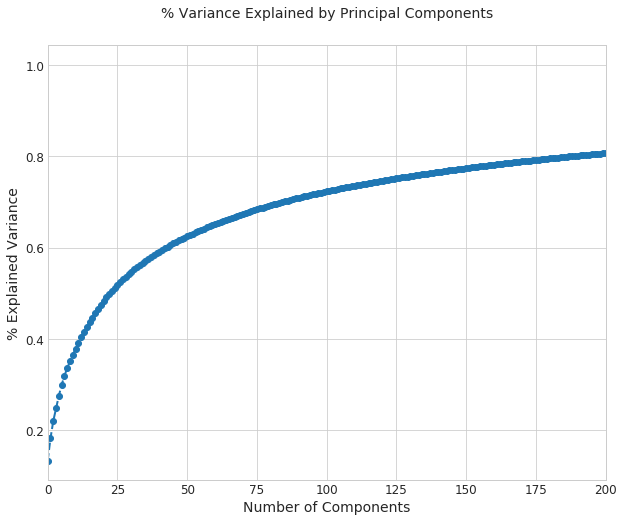

In [52]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [55]:
pca=PCA(n_components=890,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 890 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 890 components is: 0.949166995312


In [58]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

The train/test split ratio is 80:20


In [59]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,890).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.883593929639
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26131  3570    29701
True         480  4611     5091
__all__    26611  8181    34792

Accuracy of the model for test data is: 0.871594436142
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6441   972     7413
True         145  1141     1286
__all__     6586  2113     8699



Logistic Regression
Accuracy of the model for training data is: 0.888307656933
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26226  3475    29701
True         411  4680     5091
__all__    26637  8155    34792

Accuracy of the model for test data is: 0.879296470859
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6491   922     7413
True         128  1158     1286
__all__     6619  2080     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.903799724074
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26492  3209    29701
True         138  4953     5091
__all__    26630  8162    34792

Accuracy of the model for test data is: 0.89458558455
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6617   796     7413
True         121  1165     1286
__all__     6738  1961     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.885979535525
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26347  3354    29701
True         613  4478     5091
__all__    26960  7832    34792

Accuracy of the model for test data is: 0.88446947925
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6578   835     7413
True         170  1116     1286
__all__     6748  1951     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.89419981605
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26492  3209    29701
True         472  4619     5091
__all__    26964  7828    34792

Accuracy of the model for test data is: 0.891826646741
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6612   801     7413
True         140  1146     1286
__all__     6752  1947     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.905869165325
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26495  3206    29701
True          69  5022     5091
__all__    26564  8228    34792

Accuracy of the model for test data is: 0.89516036326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6615   798     7413
True         114  1172     1286
__all__     6729  1970     8699



Bagging Classifier
Accuracy of the model for training data is: 0.903512301679
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26487  3214    29701
True         143  4948     5091
__all__    26630  8162    34792

Accuracy of the model for test data is: 0.894355673066
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6605   808     7413
True         111  1175     1286
__all__     6716  1983     8699



Neural Network-1
The accuracy of the model on training data is: 0.90198896298


Predicted  False  True  __all__
Actual                         
False      26363  3338    29701
True          72  5019     5091
__all__    26435  8357    34792

The accuracy of the model on test data is: 0.889987354868


Predicted  False  True  __all__
Actual                         
False       6550   863     7413
True          94  1192     1286
__all__     6644  2055     8699

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [60]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [61]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.883594,4611.0,26131.0,3570.0,480.0,0.120198,0.094284
LogisticRegression,0.888308,4680.0,26226.0,3475.0,411.0,0.116999,0.080731
RandomForestClassifier,0.903800,4953.0,26492.0,3209.0,138.0,0.108044,0.027107
AdaBoostClassifier,0.885980,4478.0,26347.0,3354.0,613.0,0.112925,0.120409
GradientBoostingClassifier,0.894200,4619.0,26492.0,3209.0,472.0,0.108044,0.092713
ExtraTreeClassifier,0.905869,5022.0,26495.0,3206.0,69.0,0.107942,0.013553
BaggingClassifier,0.903512,4948.0,26487.0,3214.0,143.0,0.108212,0.028089
Neural Network-1,0.901989,5019.0,26363.0,3338.0,72.0,0.112387,0.014143


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.871594,1141.0,6441.0,972.0,145.0,0.131121,0.112753,0.878063
LogisticRegression,0.879296,1158.0,6491.0,922.0,128.0,0.124376,0.099533,0.888045
RandomForestClassifier,0.894586,1165.0,6617.0,796.0,121.0,0.107379,0.094090,0.899265
AdaBoostClassifier,0.884469,1116.0,6578.0,835.0,170.0,0.112640,0.132193,0.877584
GradientBoostingClassifier,0.891827,1146.0,6612.0,801.0,140.0,0.108053,0.108865,0.891541
ExtraTreeClassifier,0.895160,1172.0,6615.0,798.0,114.0,0.107649,0.088647,0.901852
BaggingClassifier,0.894356,1175.0,6605.0,808.0,111.0,0.108998,0.086314,0.902344
Neural Network-1,0.889987,1192.0,6550.0,863.0,94.0,0.116417,0.073095,0.902344


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [62]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,890).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [63]:
print('Features we will be using:\n')
http_columns.remove('domain')
display(http_columns)

Features we will be using:



['script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_href_absolute',
 'link_rel_stylesheet',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'link_type_text/css',
 'link_rel_apple-touch-icon',
 'link_type_image/png',
 'meta_charset_utf-8',
 'nav_count',
 'style_count',
 'meta_count',
 'form_count',
 'input_count',
 'link_href_.json',
 'meta_charset_

In [64]:
### Preparing our training and test sets
X=df[http_columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [67]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [68]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.930055215137
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25694   4008    29702
True         147  29555    29702
__all__    25841  33563    59404

Accuracy of the model for test data is: 0.867685940913
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6348  1064     7412
True          87  1200     1287
__all__     6435  2264     8699



Logistic Regression
Accuracy of the model for training data is: 0.885142414652
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24107   5595    29702
True        1228  28474    29702
__all__    25335  34069    59404

Accuracy of the model for test data is: 0.840786297276
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6080  1332     7412
True          53  1234     1287
__all__     6133  2566     8699



RandomForest Classifier
Accuracy of the model for training data is: 0.943606491145
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26403   3299    29702
True          51  29651    29702
__all__    26454  32950    59404

Accuracy of the model for test data is: 0.893780894356
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6592   820     7412
True         104  1183     1287
__all__     6696  2003     8699



Adaoost Classifier
Accuracy of the model for training data is: 0.901605952461
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25139   4563    29702
True        1282  28420    29702
__all__    26421  32983    59404

Accuracy of the model for test data is: 0.860903552132
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6280  1132     7412
True          78  1209     1287
__all__     6358  2341     8699



GradientBoosting Classifier
Accuracy of the model for training data is: 0.921368931385
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25775   3927    29702
True         744  28958    29702
__all__    26519  32885    59404

Accuracy of the model for test data is: 0.876652488792
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6421   991     7412
True          82  1205     1287
__all__     6503  2196     8699



ExtraTree Classifier
Accuracy of the model for training data is: 0.944145175409
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26411   3291    29702
True          27  29675    29702
__all__    26438  32966    59404

Accuracy of the model for test data is: 0.894355673066
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6600   812     7412
True         107  1180     1287
__all__     6707  1992     8699



Bagging Classifier
Accuracy of the model for training data is: 0.943269813481
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26401   3301    29702
True          69  29633    29702
__all__    26470  32934    59404

Accuracy of the model for test data is: 0.892861248419
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6571   841     7412
True          91  1196     1287
__all__     6662  2037     8699



Neural Network-1
The accuracy of the model on training data is: 0.934364689247


Predicted  False   True  __all__
Actual                          
False      25940   3762    29702
True         137  29565    29702
__all__    26077  33327    59404

The accuracy of the model on test data is: 0.876767444534


Predicted  False  True  __all__
Actual                         
False       6418   994     7412
True          78  1209     1287
__all__     6496  2203     8699

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [69]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [70]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.930055,29555.0,25694.0,4008.0,147.0,0.134940,0.004949
LogisticRegression,0.885142,28474.0,24107.0,5595.0,1228.0,0.188371,0.041344
RandomForestClassifier,0.943606,29651.0,26403.0,3299.0,51.0,0.111070,0.001717
AdaBoostClassifier,0.901606,28420.0,25139.0,4563.0,1282.0,0.153626,0.043162
GradientBoostingClassifier,0.921369,28958.0,25775.0,3927.0,744.0,0.132213,0.025049
ExtraTreeClassifier,0.944145,29675.0,26411.0,3291.0,27.0,0.110801,0.000909
BaggingClassifier,0.943270,29633.0,26401.0,3301.0,69.0,0.111137,0.002323
Neural Network-1,0.934365,29565.0,25940.0,3762.0,137.0,0.126658,0.004612


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.867686,1200.0,6348.0,1064.0,87.0,0.143551,0.067599,0.894425
LogisticRegression,0.840786,1234.0,6080.0,1332.0,53.0,0.179709,0.041181,0.889555
RandomForestClassifier,0.893781,1183.0,6592.0,820.0,104.0,0.110631,0.080808,0.904280
AdaBoostClassifier,0.860904,1209.0,6280.0,1132.0,78.0,0.152725,0.060606,0.893334
GradientBoostingClassifier,0.876652,1205.0,6421.0,991.0,82.0,0.133702,0.063714,0.901292
ExtraTreeClassifier,0.894356,1180.0,6600.0,812.0,107.0,0.109552,0.083139,0.903654
BaggingClassifier,0.892861,1196.0,6571.0,841.0,91.0,0.113465,0.070707,0.907914
Neural Network-1,0.876767,1209.0,6418.0,994.0,78.0,0.134107,0.060606,0.907914


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [72]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [82]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[http_columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",X.shape)


Shape after undersampling (12754, 50)


In [83]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [84]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [85]:
print('Features we will be using:\n')
display(http_columns)

Features we will be using:



['script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'meta_http-equiv_X-UA-Compatible',
 'link_href_https',
 'img_src_absolute',
 'img_src_https',
 'iframe_src_relative',
 'link_rel_shortcut icon',
 'iframe_src_https',
 'a_href_https',
 'link_href_.ico',
 'link_href_absolute',
 'link_rel_stylesheet',
 'img_src_.jpg',
 'link_rel_icon',
 'img_src_out_of_domain',
 'link_href_.png',
 'link_href_.css',
 'ul_count',
 'li_count',
 'link_href_out_of_domain',
 'link_type_image/x-icon',
 'link_rel_manifest',
 'iframe_src_.html',
 'span_count',
 'iframe_src_out_of_domain',
 'form_action_relative',
 'img_src_.png',
 'link_type_text/css',
 'link_rel_apple-touch-icon',
 'link_type_image/png',
 'meta_charset_utf-8',
 'nav_count',
 'style_count',
 'meta_count',
 'form_count',
 'input_count',
 'link_href_.json',
 'meta_charset_

In [86]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,http_columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.909242379692
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4489   659     5148
True         267  4788     5055
__all__     4756  5447    10203

Accuracy of the model for test data is: 0.90827126617
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1080   149     1229
True          85  1237     1322
__all__     1165  1386     2551



Logistic Regression
Accuracy of the model for training data is: 0.884053709693
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4189   959     5148
True         224  4831     5055
__all__     4413  5790    10203

Accuracy of the model for test data is: 0.895727165817
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1019   210     1229
True          56  1266     1322
__all__     1075  1476     2551



RandomForest Classifier
Accuracy of the model for training data is: 0.939919631481
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4584   564     5148
True          49  5006     5055
__all__     4633  5570    10203

Accuracy of the model for test data is: 0.916895335163
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1097   132     1229
True          80  1242     1322
__all__     1177  1374     2551



Adaoost Classifier
Accuracy of the model for training data is: 0.894932862883
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4352   796     5148
True         276  4779     5055
__all__     4628  5575    10203

Accuracy of the model for test data is: 0.909447275578
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1067   162     1229
True          69  1253     1322
__all__     1136  1415     2551



GradientBoosting Classifier
Accuracy of the model for training data is: 0.908752327747
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4449   699     5148
True         232  4823     5055
__all__     4681  5522    10203

Accuracy of the model for test data is: 0.914543316347
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1085   144     1229
True          74  1248     1322
__all__     1159  1392     2551



ExtraTree Classifier
Accuracy of the model for training data is: 0.943546015878
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4584   564     5148
True          12  5043     5055
__all__     4596  5607    10203

Accuracy of the model for test data is: 0.920031360251
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1105   124     1229
True          80  1242     1322
__all__     1185  1366     2551



Bagging Classifier
Accuracy of the model for training data is: 0.940115652259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4577   571     5148
True          40  5015     5055
__all__     4617  5586    10203

Accuracy of the model for test data is: 0.916111328891
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1091   138     1229
True          76  1246     1322
__all__     1167  1384     2551



Neural Network-1
The accuracy of the model on training data is: 0.933058904302


Predicted  False  True  __all__
Actual                         
False       4492   656     5148
True          27  5028     5055
__all__     4519  5684    10203

The accuracy of the model on test data is: 0.914151313211


Predicted  False  True  __all__
Actual                         
False       1069   160     1229
True          59  1263     1322
__all__     1128  1423     2551

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [87]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [88]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.909242,4788.0,4489.0,659.0,267.0,0.128011,0.052819
LogisticRegression,0.884054,4831.0,4189.0,959.0,224.0,0.186286,0.044313
RandomForestClassifier,0.939920,5006.0,4584.0,564.0,49.0,0.109557,0.009693
AdaBoostClassifier,0.894933,4779.0,4352.0,796.0,276.0,0.154623,0.054599
GradientBoostingClassifier,0.908752,4823.0,4449.0,699.0,232.0,0.135781,0.045895
ExtraTreeClassifier,0.943546,5043.0,4584.0,564.0,12.0,0.109557,0.002374
BaggingClassifier,0.940116,5015.0,4577.0,571.0,40.0,0.110917,0.007913
Neural Network-1,0.933059,5028.0,4492.0,656.0,27.0,0.127428,0.005341


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.908271,1237.0,1080.0,149.0,85.0,0.121237,0.064297,0.907233
LogisticRegression,0.895727,1266.0,1019.0,210.0,56.0,0.170871,0.042360,0.893385
RandomForestClassifier,0.916895,1242.0,1097.0,132.0,80.0,0.107404,0.060514,0.916041
AdaBoostClassifier,0.909447,1253.0,1067.0,162.0,69.0,0.131814,0.052194,0.907996
GradientBoostingClassifier,0.914543,1248.0,1085.0,144.0,74.0,0.117168,0.055976,0.913428
ExtraTreeClassifier,0.920031,1242.0,1105.0,124.0,80.0,0.100895,0.060514,0.919295
BaggingClassifier,0.916111,1246.0,1091.0,138.0,76.0,0.112286,0.057489,0.915112
Neural Network-1,0.914151,1263.0,1069.0,160.0,59.0,0.130187,0.044629,0.915112


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [89]:
feat_impt_plot(np.average(feat_imp,axis=0),http_columns)

In [90]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')